In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

file_path = '6_results.csv'

if not os.path.exists(file_path):
    print(f"Ошибка: Файл {file_path} не найден.")
    exit()

df = pd.read_csv(file_path)

df['Configuration'] = "Matrix N=" + df['MatrixSize'].astype(str)
modes = df['Mode'].unique()

# базовое время (T1) для каждой комбинации (MatrixSize, Mode)
# T1 берется там, где Processes == 1
base_times = {}

for mode in modes:
    for n in df['MatrixSize'].unique():
        row = df[(df['Mode'] == mode) & (df['MatrixSize'] == n) & (df['Processes'] == 1)]
        if not row.empty:
            base_times[(mode, n)] = row['Time_s'].values[0]

def get_t1(row):
    return base_times.get((row['Mode'], row['MatrixSize']), np.nan)

df['T_1'] = df.apply(get_t1, axis=1)
df['Speedup'] = df['T_1'] / df['Time_s']
df['Efficiency'] = df['Speedup'] / df['Processes']

df.head()

,Nodes,Processes,MatrixSize,Mode,Time_s,Configuration,T_1,Speedup,Efficiency
0,1,1,512,Standard,0.106609,Matrix N=512,0.106609,1.0,1.0
1,1,1,512,Synchronous,0.120875,Matrix N=512,0.120875,1.0,1.0
2,1,1,512,Buffered,0.121343,Matrix N=512,0.121343,1.0,1.0
3,1,1,1024,Standard,0.807024,Matrix N=1024,0.807024,1.0,1.0
4,1,1,1024,Synchronous,0.967315,Matrix N=1024,0.967315,1.0,1.0


Time


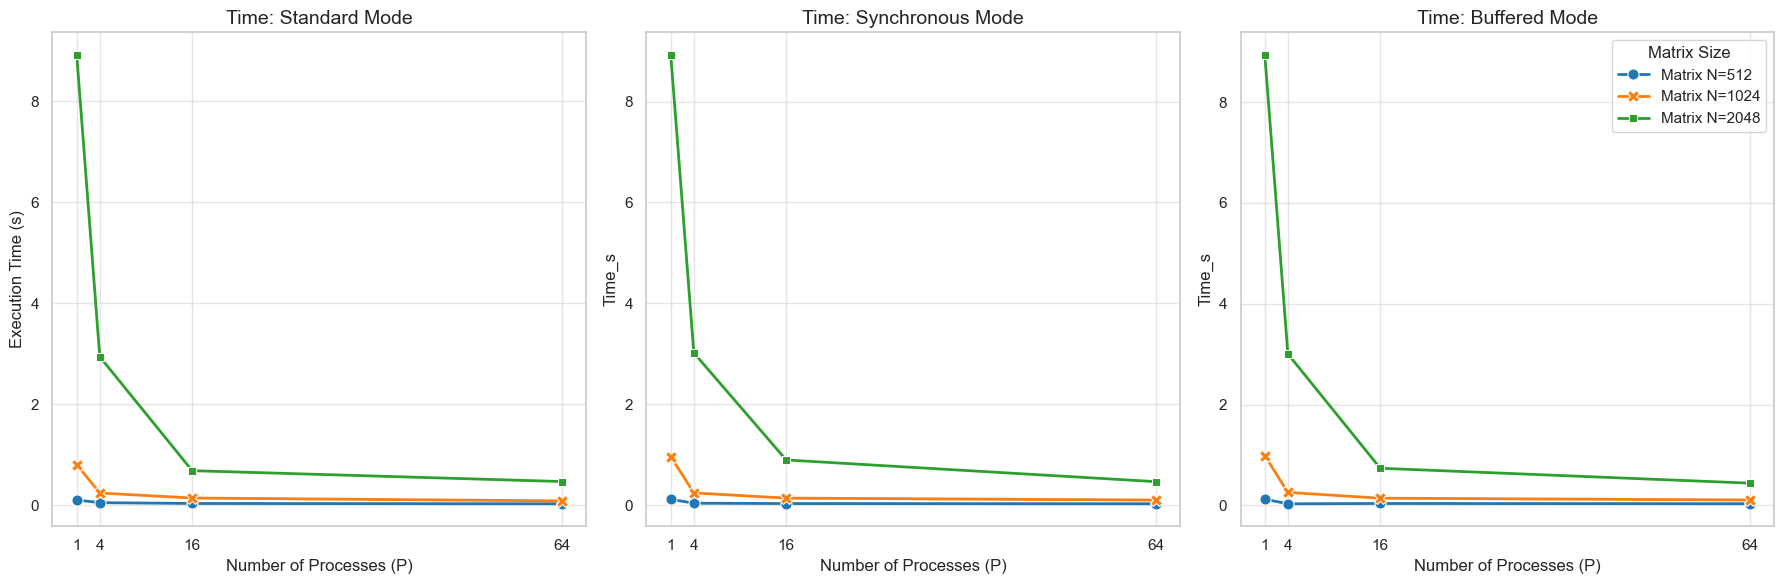

Speedup


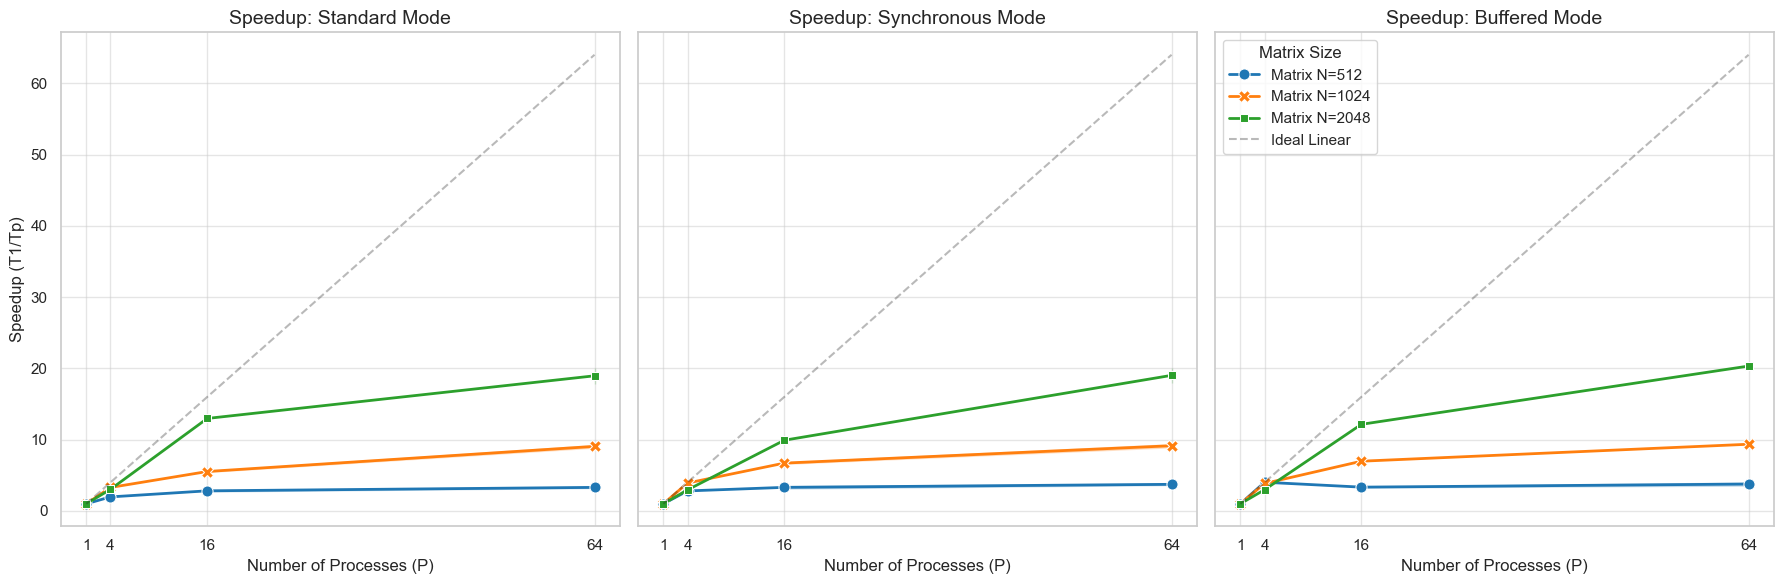

Efficiency


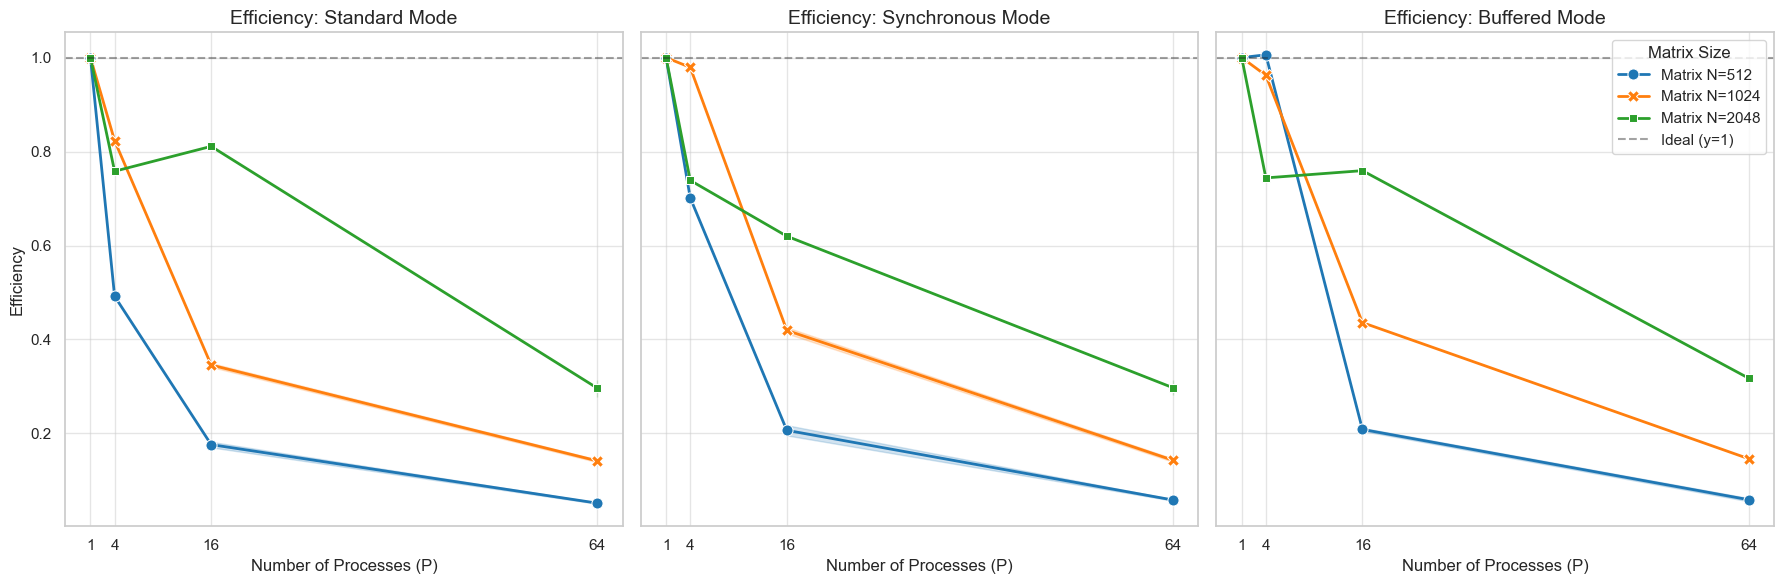

In [21]:
sns.set_theme(style="whitegrid")

def plot_mode(y_col, title, ylabel, log_y=False, ylim=None):
    print(title)

    num_modes = len(modes)
    fig, axes = plt.subplots(1, num_modes, figsize=(6 * num_modes, 6), sharey=(y_col != 'Time_s'))
    
    if num_modes == 1:
        axes = [axes]

    for i, mode in enumerate(modes):
        ax = axes[i]
        subset = df[df['Mode'] == mode].sort_values(by='Processes')

        sns.lineplot(data=subset, x='Processes', y=y_col, 
                     hue='Configuration',
                     style='Configuration', 
                     palette='tab10',
                     markers=True, dashes=False, markersize=8, linewidth=2, 
                     ax=ax)
        
        if y_col == 'Speedup':
            max_p = subset['Processes'].max()
            ax.plot([1, max_p], [1, max_p], 'k--', alpha=0.3, label='Ideal Linear')
        elif y_col == 'Efficiency':
            ax.axhline(y=1.0, color='k', linestyle='--', alpha=0.4, label='Ideal (y=1)')

        ax.set_title(f'{title}: {mode} Mode', fontsize=14)
        ax.set_xlabel('Number of Processes (P)', fontsize=12)
        if i == 0:
            ax.set_ylabel(ylabel, fontsize=12)

        if log_y:
            ax.set_yscale('log', base=10) 
        if ylim:
            ax.set_ylim(ylim)
        
        ax.set_xticks(sorted(subset['Processes'].unique()))
        ax.grid(True, which="both", ls="-", alpha=0.5)
        
        if i == num_modes - 1:
            ax.legend(title='Matrix Size', loc='best', frameon=True)
        else:
            if ax.get_legend(): ax.get_legend().remove()

    plt.tight_layout()
    plt.show()


plot_mode('Time_s', 'Time', 'Execution Time (s)')
plot_mode('Speedup', 'Speedup', 'Speedup (T1/Tp)')
plot_mode('Efficiency', 'Efficiency', 'Efficiency')